#### Testeo Modelos 
En este sección vamos a realizar testeos de los diferentes modelos que se guardaron.

Recorda que hicimos entrenamiento por separado. Por un lado tenemos un entrenamiento basado solo en 
latitudes y longitudes, es decir un modelo de predicción de latitudes y longitudes, y por otro lado se tiene un modelo dedicado solo a la prediccion de las alturas. 

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
import pickle
from Utils import plotter as utlnn
from Utils import geo_conversions as gc
%matplotlib widget

In [23]:
#Carga conjunto de Test.

x_test = pd.read_excel("./Train_Test/Dataset_Separado/x_test_new.xlsx")
y_test = pd.read_excel("./Train_Test/Dataset_Separado/y_test_new.xlsx")


In [24]:
# Quita de columnas no usadas en Train 
x_test = x_test.drop(columns=['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [25]:
#Carga de Modelos Entrenados.
autoencoder_x =  load_model('./modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/modelo1_x.keras')
with open('./modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/scaler_x1.pkl', 'rb') as f:
  scaler_x = pickle.load(f)

autoencoder_y = load_model('./modelos_entrenamiento/mod_y_R0/modelo1_y_con_scaler/modelo1_y.keras')
with open('./modelos_entrenamiento/mod_y_R0/modelo1_y_con_scaler/scaler_y1.pkl', 'rb') as f:
  scaler_y = pickle.load(f)
  
autoencoder_z = load_model('./modelos_entrenamiento/mod_z_R0/modelo1_con_scaler/modelo1.keras')
with open('./modelos_entrenamiento/mod_z_R0/modelo1_con_scaler/scaler_z1.pkl','rb') as f:
  scaler_z = pickle.load(f)



In [26]:
# Valores verdaderos
idx = 20
R0 = 6.371E6


y_true_x = (y_test.iloc[idx].to_numpy())[0:100]/R0
y_true_y = (y_test.iloc[idx].to_numpy())[100:200]/R0
y_true_z = (y_test.iloc[idx].to_numpy())[200:300]/R0

# Predicciones
y_pred_scaled_x = autoencoder_x.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_pred_scaled_y = autoencoder_y.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_pred_scaled_z = autoencoder_z.predict(np.expand_dims(x_test.iloc[idx], axis = 0))

y_pred_x = scaler_x.inverse_transform(y_pred_scaled_x).flatten()
y_pred_y = scaler_y.inverse_transform(y_pred_scaled_y).flatten()
y_pred_z = scaler_z.inverse_transform(y_pred_scaled_z).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


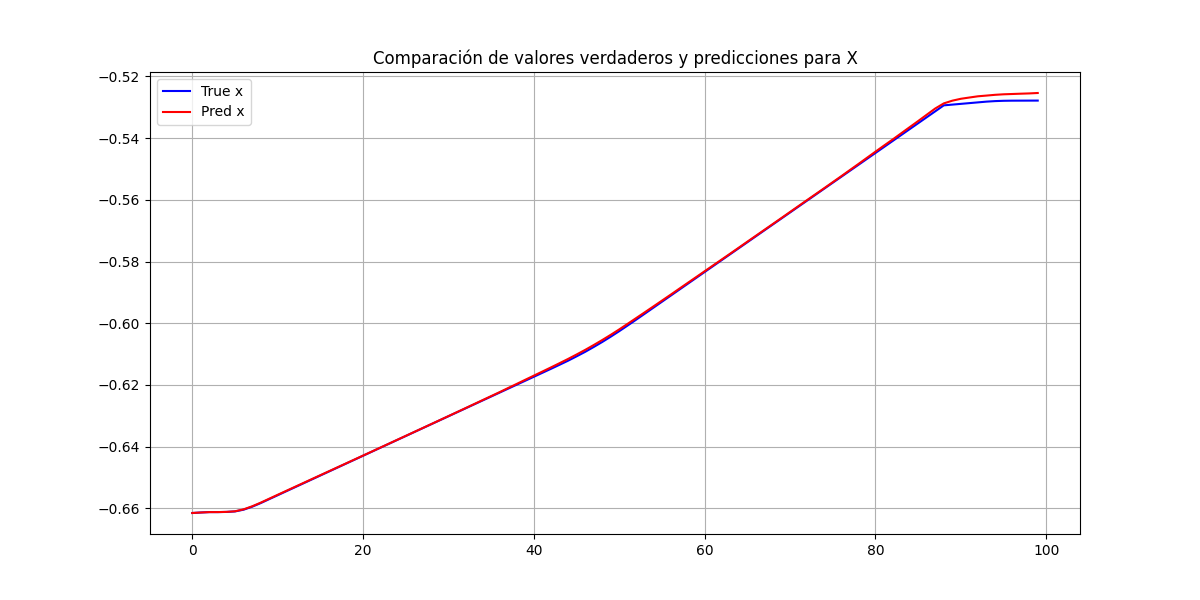

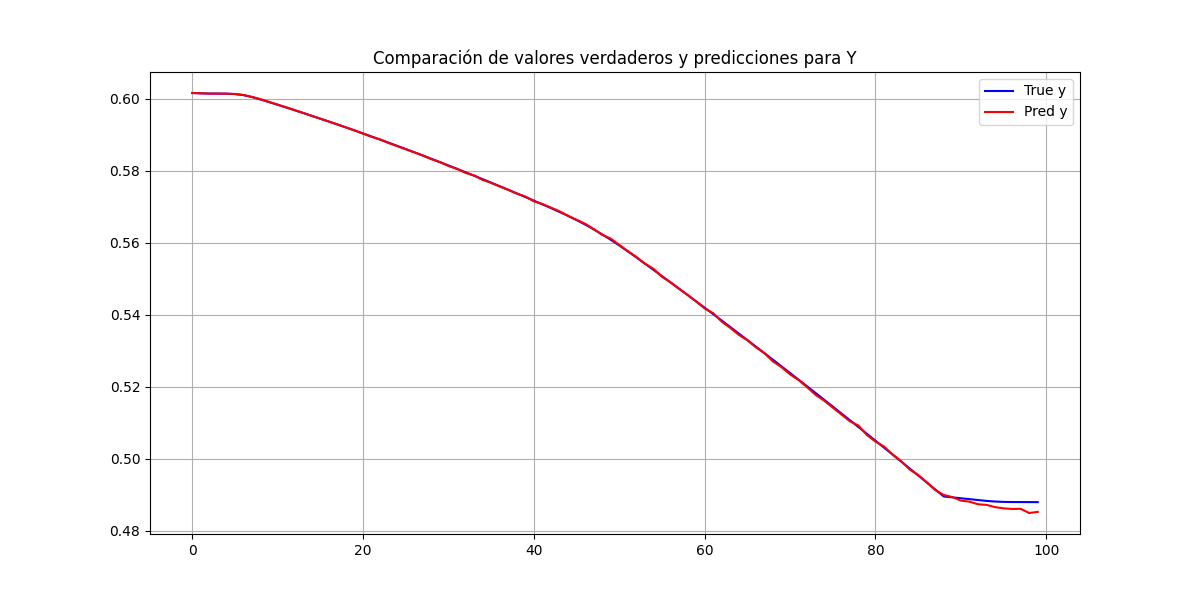

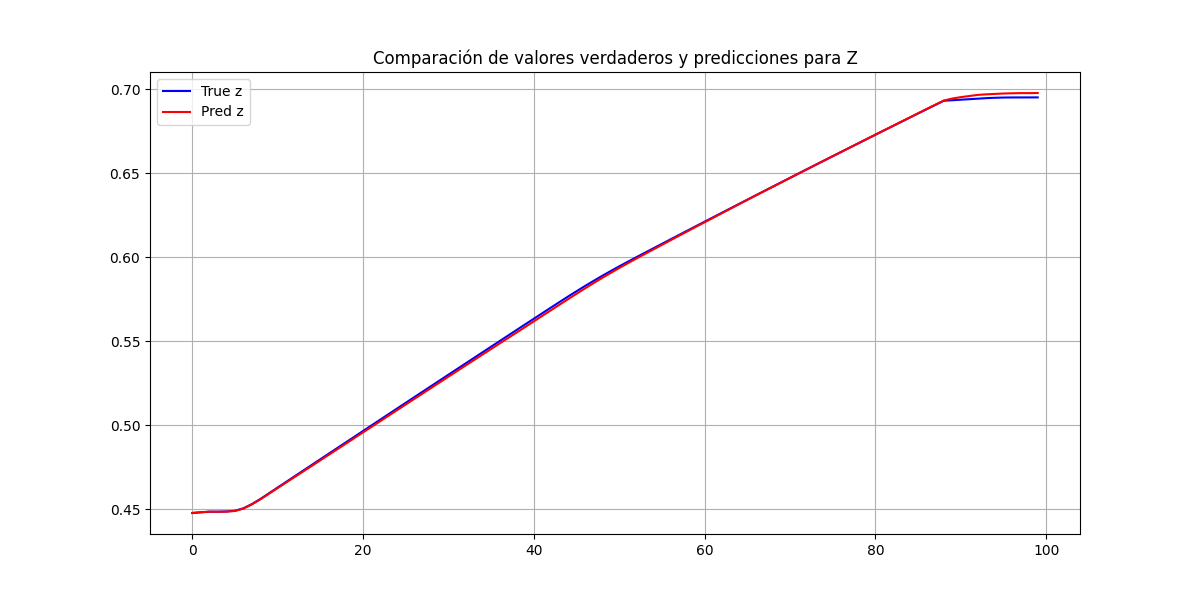

In [27]:
# Graficar resultados
plt.figure(figsize = (12,6))
plt.plot(y_true_x, label = 'True x', color = 'blue')
plt.plot(y_pred_x, label = 'Pred x', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para X')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(y_true_y, label = 'True y', color = 'blue')
plt.plot(y_pred_y, label = 'Pred y', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para Y')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(y_true_z, label = 'True z', color = 'blue')
plt.plot(y_pred_z, label = 'Pred z', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para Z')
plt.grid(True)
plt.legend()
plt.show()


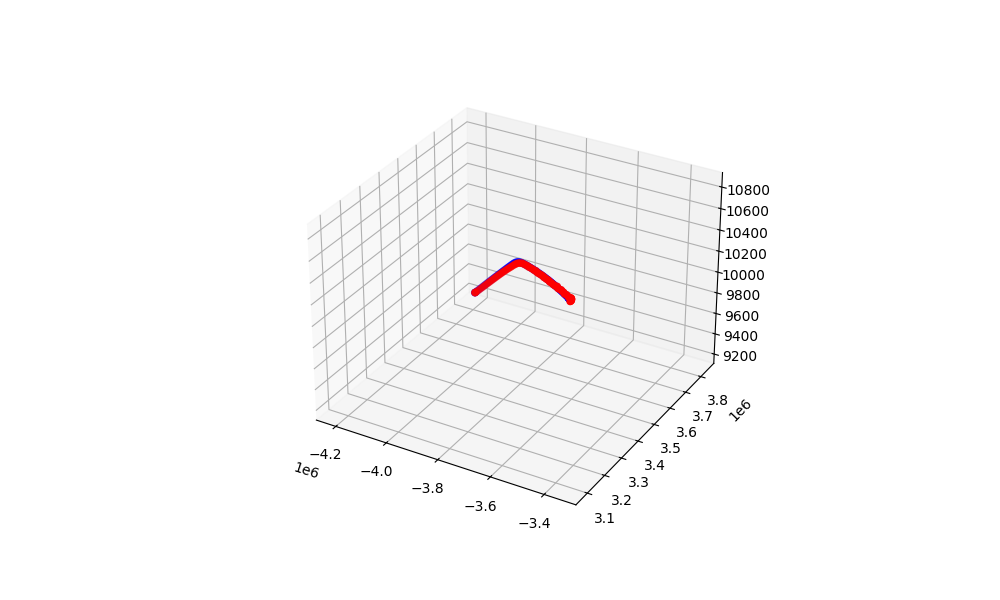

In [34]:
# Gráficos de resultado 3D

# utlnn.plot_3D(y_true_x*R0, y_true_y*R0, y_true_z*R0)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection = '3d')
ax.scatter(y_true_x*R0, y_true_y*R0, (y_true_z*R0 + R0)/1000, c='blue', label='True')
ax.scatter(y_pred_x*R0, y_pred_y*R0, (y_pred_z*R0+R0)/1000, c='red', label='Pred')


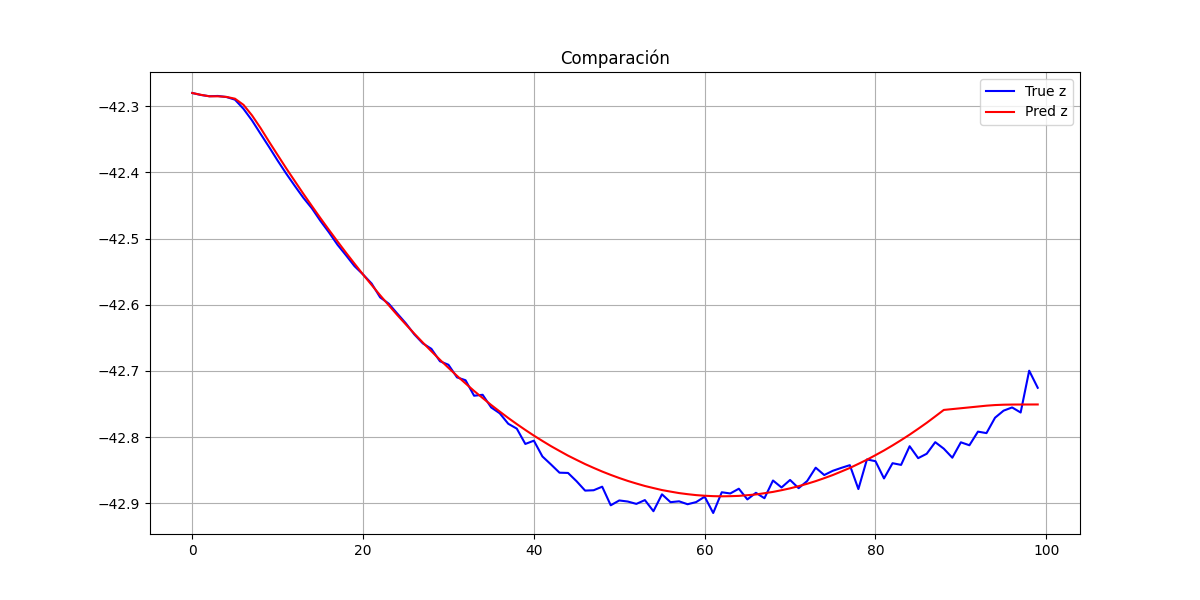

In [35]:
phi_true, theta_true, r_true = gc.transform_cartesian_to_spherical(y_true_x*R0, y_true_y*R0, y_true_z*R0)
phi_pred, theta_pred, r_pred = gc.transform_cartesian_to_spherical(y_pred_x*R0, y_pred_y*R0, y_pred_z*R0)

lat_pred, lon_pred, alt_pred = gc.transform_spherical_to_geographic(phi_pred, theta_pred, r_pred)
lat_true, lon_true, alt_true = gc.transform_spherical_to_geographic(phi_true, theta_true, r_true)

plt.figure(figsize = (12,6))
plt.plot(lat_pred, label = 'True z', color = 'blue')
plt.plot(lat_true, label = 'Pred z', color = 'red')
plt.title('Comparación')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# NOTAS:-----------------------
#De aqui en adelante aún no se trato.

## Errores 
1. Error de manera individual:
  * Puedo calcular $d_{2D}$ usando **geopy.distance.geodesic**.
  * Luego calcular la diferencia de alturas $\Delta z$
  * Finalmente usar un $d_{3D} = \sqrt{(d_{2D})^2 + (\Delta z)^2}$ y así obtendría mi distancia en 3D.
2. ECM
  * Para obtener el Error Cuadrático Medio puedo, sumar los valores y dividir por la cantidad de puntos (100 puntos)
3. RECM(RMSE)
  * Por último se podría tomar la raiz del ECM para expresar el error promedio en metros.

In [30]:
# Distance_havers = utlnn.haversine_distance(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes)
Distance_havers = utlnn.haversine_distance(y_true_latitudes,y_true_longitudes,lat_pred)

AttributeError: module 'Utils.plotter' has no attribute 'haversine_distance'

In [ ]:
plot = False
# Calculamos el error 
error = np.sum(Distance_havers**2)/len(Distance_havers)
print("Raiz del ECM:",np.sqrt(error))

if plot == True:
  plt.figure(figsize=(15,6))
  plt.bar(range(len(Distance_havers)), Distance_havers, color='skyblue')
  plt.xlabel('Índice')
  plt.ylabel('Error (distancia)')
  plt.title('Errores como distancias')
  plt.show()

In [ ]:
# distance = utlnn.distances_by_geodesic(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes) #Km
distance = utlnn.distances_by_geodesic(y_true_latitudes,y_true_longitudes,lat_pred,lon_pred) #Km
print(f"distancia 2D: {distance}")
sq_distance = distance**2
error_2d = np.sum(sq_distance)/len(sq_distance) #ECM
sqrt_error_2d = np.sqrt(error_2d)
print("Raiz del error ECM:",error_2d,sqrt_error_2d)


In [ ]:
plot1 = False
if plot1 == True:
  plt.figure(figsize=(15,6))
  plt.bar(range(len(distance)), distance, color='skyblue')
  plt.xlabel('Índice')
  plt.ylabel('Error (distancia)')
  plt.title('Errores como distancias 2D Km')
  plt.show()

In [ ]:
distance_3d = utlnn.distances_3D(distance,y_true_heights,y_pred_heights)   
plot = False 
if plot == True:
  plt.figure(figsize=(15,6))
  plt.bar(range(len(distance_3d)), distance_3d, color='skyblue')
  plt.xlabel('Índice')
  plt.title('Errores como distancias 2D Km')
  plt.show()
print(distance_3d)